# Notebook Thesis: Predicting Air Quality in the Netherlands
## Author: Mark Nauta

## Overview
#### 1. Reading Weather Data
#### 2. Reading Air Quality Data
#### 3. Merge Data and finalize Cleaning
#### 4. EDA, Missing Values and Outliers
#### 5. Prepare Data for Learning
#### 6. Train Machine Learning + Deep Learning Models and Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Reading Weather Data

In [2]:
# weather files 
de_bilt = pd.read_csv('../Data/Weather_uur/De_Bilt_260.txt', skiprows=31, skipinitialspace=True)
cabauw = pd.read_csv('../Data/Weather_uur/Cabauw_348.txt', skiprows=31, skipinitialspace=True)

def change_hour(inp):
    if len(inp) == 1:
        return '0'+inp
    return inp

#  pre-process weather dataframes
def pre_process(weather_df, year_end):
    # selecting columns
    weather_df = weather_df.loc[:, ['# STN', 'YYYYMMDD', 'HH', 'T', 'FH', 'U']]
    weather_df.rename(columns={'# STN': 'Station', 'YYYYMMDD': 'Date', 'HH': 'Hour', 'U': 'Humidity'}, inplace=True)

    # correct scale
    weather_df['Temp_c'] = weather_df['T'] / 10
    weather_df['Wind_ms'] = weather_df['FH'] / 10

    # formatting date
    weather_df['Date'] = weather_df['Date'].astype(str)
    weather_df['Year'] = weather_df['Date'].map(lambda x: x[:4]).astype(int)

    # formatting Hour colomn
    weather_df['Hour'] = weather_df['Hour'].map(lambda x: x - 1)
    weather_df['Hour'] = weather_df['Hour'].astype(str)
    weather_df['Hour'] = weather_df['Hour'].map(lambda x: change_hour(x))

    # formal date
    weather_df['Date_Formal'] = weather_df['Date'].str[:4]+'-'+weather_df['Date'].str[4:6]+'-'+weather_df['Date'].str[6:]+' '+weather_df['Hour']

    # relevant columns
    weather_df = weather_df.loc[:, ['Date_Formal', 'Year', 'Temp_c', 'Wind_ms', 'Humidity']]

    # filter data based on year
    weather_final = weather_df[weather_df['Year'] <= year_end]
    return weather_final 

# final weather dataframes
weather_de_bilt = pre_process(de_bilt, 2022)
weather_cabauw = pre_process(cabauw, 2022)

In [3]:
# outcome
weather_de_bilt.head()

,Date_Formal,Year,Temp_c,Wind_ms,Humidity
0,2021-01-01 00,2021,-2.5,1.0,98
1,2021-01-01 01,2021,-3.2,1.0,98
2,2021-01-01 02,2021,-2.7,2.0,98
3,2021-01-01 03,2021,-1.1,2.0,98
4,2021-01-01 04,2021,1.1,2.0,95


## 2. Reading Air Quality Data

In [4]:
# 4 stations with unique locations; the names correspond with RIVM names
full_stations = {'Utrecht-Kardinaal de Jongweg': 'NL10636', 'Breukelen-Snelweg': 'NL10641', 'Utrecht-Griftpark': 'NL10643',
                'Cabauw-Wielsekade': 'NL10644'}
stations_code = ['NL10636', 'NL10641', 'NL10643', 'NL10644']
stations_name = ['1. Utrecht-Kardinaal de Jongweg', '2. Breukelen-Snelweg', '3. Utrecht-Griftpark', '4. Cabauw-Wielsekade']

In [5]:
# reading 2021 PM2.5 file
pm25_2021 = pd.read_csv('../Data/PM2_5/2021_PM25.csv', skiprows=7, sep=';')

# reading 2022 PM2.5 files
pm25_2022_01 = pd.read_csv('../Data/PM2_5/2022_01_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_02 = pd.read_csv('../Data/PM2_5/2022_02_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_03 = pd.read_csv('../Data/PM2_5/2022_03_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_04 = pd.read_csv('../Data/PM2_5/2022_04_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_05 = pd.read_csv('../Data/PM2_5/2022_05_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_06 = pd.read_csv('../Data/PM2_5/2022_06_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_07 = pd.read_csv('../Data/PM2_5/2022_07_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)
pm25_2022_08 = pd.read_csv('../Data/PM2_5/2022_08_PM25.csv', skiprows=7, sep=';', skipinitialspace=True)

pm25_2022_all = [pm25_2022_01, pm25_2022_02, pm25_2022_03, pm25_2022_04, pm25_2022_05, pm25_2022_06,
                 pm25_2022_07, pm25_2022_08]

# pre-process PM2.5 data
def pre_process(df, dfs_2022, station):

    # correct columns 2021 data
    df = df.loc[:, ['Component', 'Eenheid', 'Begindatumtijd', station]]

    # format time
    df['Date'] = df['Begindatumtijd'].map(lambda x: x[:8])
    df['Hour'] = df['Begindatumtijd'].map(lambda x: x[9:11])

    # formal date
    df['Date_Formal'] = df['Date'].str[:4]+'-'+df['Date'].str[4:6]+'-'+df['Date'].str[6:]+' '+df['Hour']

    # selecting final columns
    df_final = df.loc[:, ['Date_Formal', 'Hour', station]]
    df_final.rename(columns={station: 'PM_25'}, inplace=True)  

    # 2022 data
    for df_2022 in dfs_2022:
        # correct columns
        df_2022 = df_2022.loc[:, ['Component', 'Eenheid', 'Begindatumtijd', station]]

        # format time
        df_2022['Date'] = df_2022['Begindatumtijd'].map(lambda x: x[:8])
        df_2022['Hour'] = df_2022['Begindatumtijd'].map(lambda x: x[9:11])

        # formal date
        df_2022['Date_Formal']=df_2022['Date'].str[:4]+'-'+df_2022['Date'].str[4:6]+'-'+df_2022['Date'].str[6:]+' '+df_2022['Hour']

        # selecting final columns
        df_2022 = df_2022.loc[:, ['Date_Formal', 'Hour', station]]
        df_2022.rename(columns={station: 'PM_25'}, inplace=True)

        df_final = pd.concat([df_final, df_2022])

    # reseting index and selecting correct columns
    df_final = df_final.reset_index().loc[:, ['Date_Formal', 'Hour', 'PM_25']]
    df_final.sort_values(by=['Date_Formal'])
    return df_final

# function with the correct rivm station codes
Utrecht_Kar = pre_process(pm25_2021, pm25_2022_all, stations_code[0])
Breukelen = pre_process(pm25_2021, pm25_2022_all, stations_code[1])
Utrecht_Gri = pre_process(pm25_2021, pm25_2022_all, stations_code[2])
Cabauw = pre_process(pm25_2021, pm25_2022_all, stations_code[3])

In [6]:
# confirming
Utrecht_Kar.head(9)
# Breukelen.head(9)
# Utrecht_Gri.head(9)
# Cabauw.head(9)

,Date_Formal,Hour,PM_25
0,2021-01-01 00,00,316.518
1,2021-01-01 01,01,299.466
2,2021-01-01 02,02,124.536
3,2021-01-01 03,03,121.008
4,2021-01-01 04,04,132.768
5,2021-01-01 05,05,134.434
6,2021-01-01 06,06,90.746
7,2021-01-01 07,07,40.942
8,2021-01-01 08,08,22.665


## 3. Merge Data and finalize import

In [7]:
# merge first three measurement stations with de Bilt weather
Utrecht_Kar_tot = pd.merge(Utrecht_Kar, weather_de_bilt, on='Date_Formal', how='left')
Breukelen_tot = pd.merge(Breukelen, weather_de_bilt, on='Date_Formal', how='left')
Utrecht_Gri_tot = pd.merge(Utrecht_Gri, weather_de_bilt, on='Date_Formal', how='left')

# merge cabauw measurement station with cabauw weather station
Cabauw_tot = pd.merge(Cabauw, weather_cabauw, on='Date_Formal', how='left')

In [8]:
# confirming
Utrecht_Kar_tot.head(9)
# Breukelen_tot.head(9)
# Utrecht_Gri_tot.head(9)
# Cabauw_tot.head(9)

,Date_Formal,Hour,PM_25,Year,Temp_c,Wind_ms,Humidity
0,2021-01-01 00,00,316.518,2021,-2.5,1.0,98
1,2021-01-01 01,01,299.466,2021,-3.2,1.0,98
2,2021-01-01 02,02,124.536,2021,-2.7,2.0,98
3,2021-01-01 03,03,121.008,2021,-1.1,2.0,98
4,2021-01-01 04,04,132.768,2021,1.1,2.0,95
5,2021-01-01 05,05,134.434,2021,1.9,3.0,92
6,2021-01-01 06,06,90.746,2021,2.2,2.0,90
7,2021-01-01 07,07,40.942,2021,2.7,3.0,89
8,2021-01-01 08,08,22.665,2021,3.1,2.0,90


### Final Data Clean Steps

In [9]:
def hour_int(x):
    if x[0] == '0':
        return int(x[1])+1
    return int(x)+1

def month_int(x):
    if x[0] == '0':
        return int(x[1])
    return int(x)

# clean data
def final_clean(df):
    df['Date_Formal'] = pd.to_datetime(df['Date_Formal'], format='%Y-%m-%d %H')
    df['Year'] = df['Date_Formal'].dt.strftime('%Y')
    df['Month'] = df['Date_Formal'].dt.strftime('%m')
    df['Month_int'] = df['Month'].map(lambda x: month_int(x))
    df['Month_unique'] = df['Year']+'-'+df['Month']

    df['Week'] = df['Date_Formal'].dt.strftime('%W')
    df['Week_Day'] = df['Date_Formal'].dt.weekday + 1
    df['Day'] = df['Date_Formal'].dt.strftime('%d')
    df['Hour'] = df['Date_Formal'].dt.strftime('%H')
    df['Date'] = df['Year']+'-'+df['Month']+'-'+df['Day']

    # cyclical encoding month of year
    df['Month_cos'] = np.cos(2 * np.pi * df['Month_int'] / df['Month_int'].max())
    df['Month_sin'] = np.sin(2 * np.pi * df['Month_int'] / df['Month_int'].max())    
    # cyclical encoding weekday
    df['WeekDay_cos'] = np.cos(2 * np.pi * df['Week_Day'] / df['Week_Day'].max())
    df['WeekDay_sin'] = np.sin(2 * np.pi * df['Week_Day'] / df['Week_Day'].max())
    # cyclical encoding hour
    df['Hour_int'] = df['Hour'].map(lambda x: hour_int(x))
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour_int'] / df['Hour_int'].max())
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour_int'] / df['Hour_int'].max())
    
    # correct order
    return df.loc[:, ['Date_Formal', 'Date', 'Month', 'Month_unique', 'Week', 'Week_Day', 'Day', 'Hour',
                       'PM_25', 'Temp_c', 'Wind_ms', 'Humidity', 
                       'Month_cos', 'Month_sin', 'WeekDay_cos', 'WeekDay_sin', 'Hour_cos', 'Hour_sin']]

# finalize 4 final dataframes
Utrecht_Kar_end = final_clean(Utrecht_Kar_tot)
Breukelen_end = final_clean(Breukelen_tot)
Utrecht_Gri_end = final_clean(Utrecht_Gri_tot)
Cabauw_end = final_clean(Cabauw_tot)

dfs_all = [Utrecht_Kar_end, Breukelen_end, Utrecht_Gri_end, Cabauw_end]

In [10]:
# outcomes cleaning
Utrecht_Kar_end.head(9)
# Breukelen_end.head(9)
# Utrecht_Gri_end.head(9)
# Cabauw_end.head(9)

,Date_Formal,Date,Month,Month_unique,Week,Week_Day,Day,Hour,PM_25,Temp_c,Wind_ms,Humidity,Month_cos,Month_sin,WeekDay_cos,WeekDay_sin,Hour_cos,Hour_sin
0,2021-01-01 00:00:00,2021-01-01,01,2021-01,00,5,01,00,316.518,-2.5,1.0,98,0.866025,0.5,-0.222521,-0.974928,9.659258e-01,0.258819
1,2021-01-01 01:00:00,2021-01-01,01,2021-01,00,5,01,01,299.466,-3.2,1.0,98,0.866025,0.5,-0.222521,-0.974928,8.660254e-01,0.500000
2,2021-01-01 02:00:00,2021-01-01,01,2021-01,00,5,01,02,124.536,-2.7,2.0,98,0.866025,0.5,-0.222521,-0.974928,7.071068e-01,0.707107
3,2021-01-01 03:00:00,2021-01-01,01,2021-01,00,5,01,03,121.008,-1.1,2.0,98,0.866025,0.5,-0.222521,-0.974928,5.000000e-01,0.866025
4,2021-01-01 04:00:00,2021-01-01,01,2021-01,00,5,01,04,132.768,1.1,2.0,95,0.866025,0.5,-0.222521,-0.974928,2.588190e-01,0.965926
5,2021-01-01 05:00:00,2021-01-01,01,2021-01,00,5,01,05,134.434,1.9,3.0,92,0.866025,0.5,-0.222521,-0.974928,6.123234e-17,1.000000
6,2021-01-01 06:00:00,2021-01-01,01,2021-01,00,5,01,06,90.746,2.2,2.0,90,0.866025,0.5,-0.222521,-0.974928,-2.588190e-01,0.965926
7,2021-01-01 07:00:00,2021-01-01,01,2021-01,00,5,01,07,40.942,2.7,3.0,89,0.866025,0.5,-0.222521,-0.974928,-5.000000e-01,0.866025
8,2021-01-01 08:00:00,2021-01-01,01,2021-01,00,5,01,08,22.665,3.1,2.0,90,0.866025,0.5,-0.222521,-0.974928,-7.071068e-01,0.707107


## 4. EDA 

### 4.1.1. Plot PM2.5 trends over different time steps

In [11]:
# plot for PM2.5 for four measurement stations of given time_period 
def plot_PM_25(dfs, time_period, name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

    # groupby, the specific date object
    df_group1 = dfs[0].groupby(time_period)['PM_25'].mean()  
    df_group2 = dfs[1].groupby(time_period)['PM_25'].mean()  
    df_group3 = dfs[2].groupby(time_period)['PM_25'].mean()  
    df_group4 = dfs[3].groupby(time_period)['PM_25'].mean()  

    # top left: Utrecht Kardinaal 
    axes[0, 0].plot([x for x in range(len(df_group1))], df_group1)
    axes[0, 0].set_xlabel(name)
    axes[0, 0].set_ylabel('PM2.5 µg/m³')
    axes[0, 0].set_title(stations_name[0], fontsize=13.6)

    if time_period == 'Hour':
        axes[0, 0].set_xticks([0, 4, 8, 12, 16, 20], ['00:00', '04:00', '08:00', '12:00', '16:00','20:00'], fontsize=11)
    elif time_period == 'Week_Day':
        axes[0, 0].set_xticks([x for x in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=11)
    elif time_period == 'Month':
        axes[0, 0].set_xticks([x for x in range(12)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                                       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

    # top right: Breukelen
    axes[0, 1].plot([x for x in range(len(df_group2))], df_group2)
    axes[0, 1].set_xlabel(name)
    axes[0, 1].set_ylabel('PM2.5 µg/m³')
    axes[0, 1].set_title(stations_name[1], fontsize=13.6)
 
    if time_period == 'Hour':
        axes[0, 1].set_xticks([0, 4, 8, 12, 16, 20], ['00:00', '04:00', '08:00', '12:00', '16:00','20:00'], fontsize=11)
    elif time_period == 'Week_Day':
        axes[0, 1].set_xticks([x for x in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=11)
    elif time_period == 'Month':
        axes[0, 1].set_xticks([x for x in range(12)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                                       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

    # left lower: Utrecht Griftpark
    axes[1, 0].plot([x for x in range(len(df_group3))], df_group3)
    axes[1, 0].set_xlabel(name)
    axes[1, 0].set_ylabel('PM2.5 µg/m³')
    axes[1, 0].set_title(stations_name[2], fontsize=13.6)

    if time_period == 'Hour':
        axes[1, 0].set_xticks([0, 4, 8, 12, 16, 20], ['00:00', '04:00', '08:00', '12:00', '16:00','20:00'], fontsize=11)
    elif time_period == 'Week_Day':
        axes[1, 0].set_xticks([x for x in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=11)
    elif time_period == 'Month':
        axes[1, 0].set_xticks([x for x in range(12)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                                       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

    # right lower: Cabauw
    axes[1, 1].plot([x for x in range(len(df_group4))], df_group4)
    axes[1, 1].set_xlabel(name)
    axes[1, 1].set_ylabel('PM2.5 µg/m³')
    axes[1, 1].set_title(stations_name[3], fontsize=13.6)

    if time_period == 'Hour':
        axes[1, 1].set_xticks([0, 4, 8, 12, 16, 20], ['00:00', '04:00', '08:00', '12:00', '16:00','20:00'], fontsize=11)
    elif time_period == 'Week_Day':
        axes[1, 1].set_xticks([x for x in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=11)
    elif time_period == 'Month':
        axes[1, 1].set_xticks([x for x in range(12)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                                       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

    plt.savefig(f'../Pictures/Output_More/EDA/pm25_trend_{time_period}.jpg', dpi=600)
    plt.show()

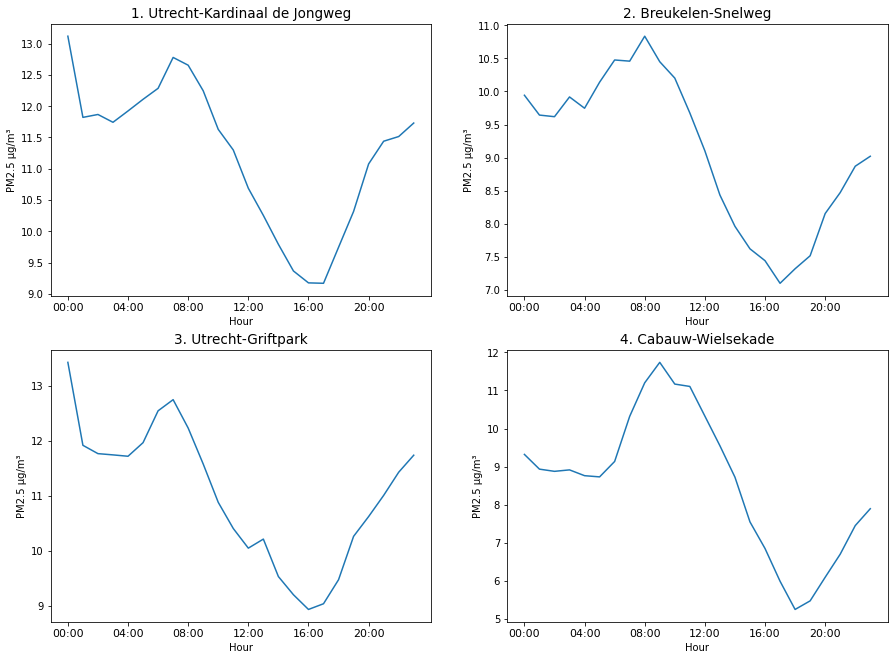

In [12]:
# calling function with 'Hour' timeperiod
plot_PM_25(dfs_all, 'Hour', name='Hour')

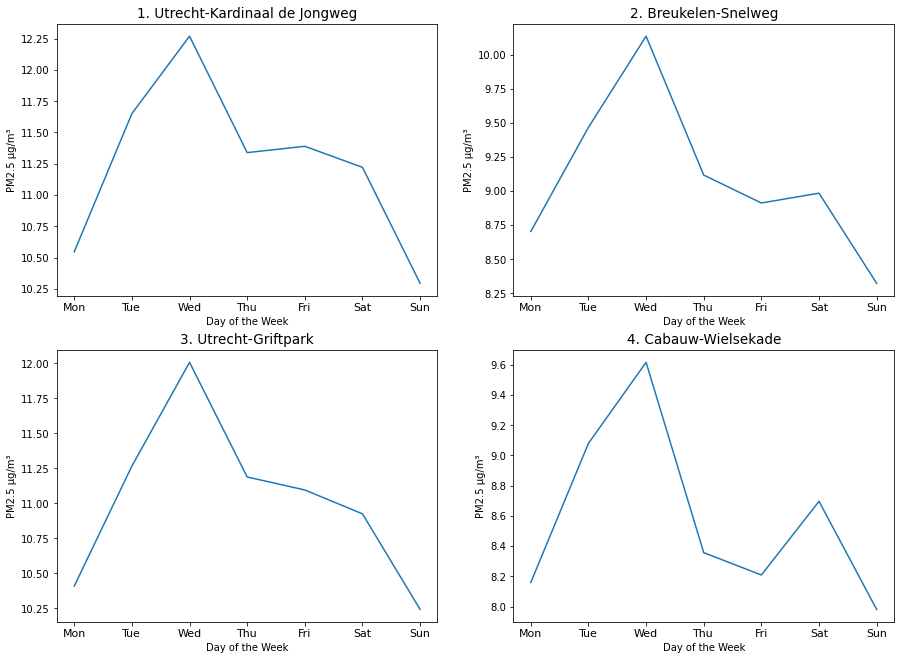

In [13]:
# calling function with 'Day_Week' timeperiod
plot_PM_25(dfs_all, 'Week_Day', name='Day of the Week')

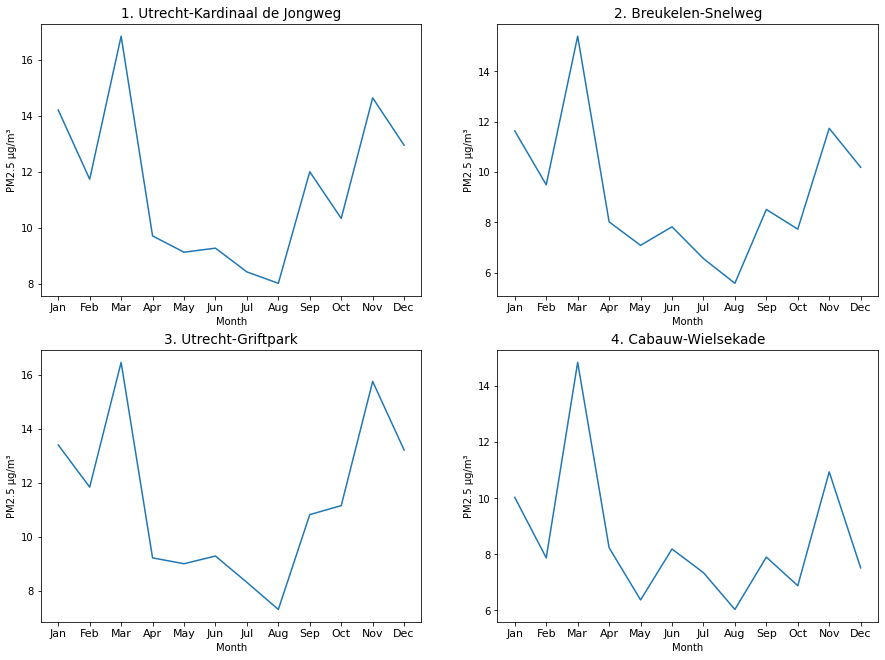

In [14]:
# calling function with 'Day_Week' timeperiod
plot_PM_25(dfs_all, 'Month', name='Month')

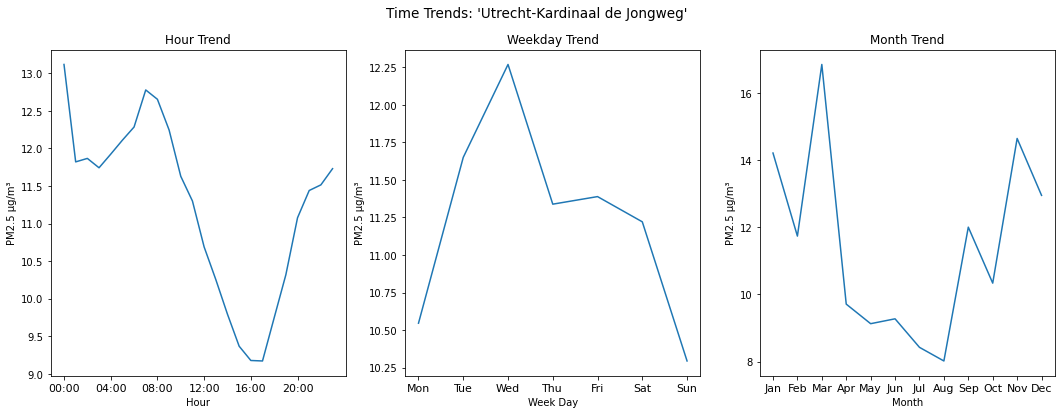

In [15]:
# plot PM2.5 one station, all time periods
def plot_PM_25_all(dfs, which=0):
    fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

    # groupby, the specific date object
    df_group1 = dfs[which].groupby('Hour')['PM_25'].mean()  
    df_group2 = dfs[which].groupby('Week_Day')['PM_25'].mean()  
    df_group3 = dfs[which].groupby('Month')['PM_25'].mean()  

    # left: Hour
    axes[0].plot([x for x in range(len(df_group1))], df_group1)
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('PM2.5 µg/m³')
    axes[0].set_title('Hour Trend', fontsize=12)
    axes[0].set_xticks([0, 4, 8, 12, 16, 20], ['00:00', '04:00', '08:00', '12:00', '16:00','20:00'], fontsize=11)

    # Middle: Weekday
    axes[1].plot([x for x in range(len(df_group2))], df_group2)
    axes[1].set_xlabel('Week Day')
    axes[1].set_ylabel('PM2.5 µg/m³')
    axes[1].set_title('Weekday Trend', fontsize=12)
    axes[1].set_xticks([x for x in range(7)], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=11)

    # Right: Month
    axes[2].plot([x for x in range(len(df_group3))], df_group3)
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('PM2.5 µg/m³')
    axes[2].set_title('Month Trend', fontsize=12)
    axes[2].set_xticks([x for x in range(12)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                                                       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=11)

    fig.suptitle(f"Time Trends: '{stations_name[which][3:]}'", fontsize=13.6)
    plt.savefig(f'../Pictures/Output_More/EDA/pm25_trend_all.jpg', dpi=600)
    plt.show()

plot_PM_25_all(dfs_all, which=0)

### 4.1.2. Show Cyclical Encoding

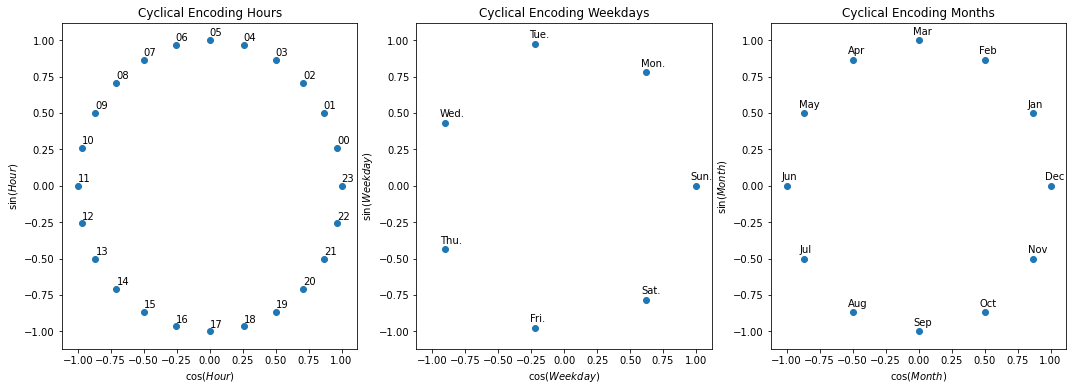

In [16]:
def plot_cyclical():
    # data to show
    hours = np.array([x for x in range(1, 25)])
    hour_text = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
                  '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
    weekdays = np.array([x for x in range(1, 8)])
    weekday_text = ['Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.', 'Sun.']
    months = np.array([x for x in range(1, 13)])
    months_text = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                    'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

    # cyclical hours
    axes[0].scatter(np.cos(2 * np.pi * hours / hours.max()), 
                    np.sin(2 * np.pi * hours / hours.max()))
    # marker text hours
    for i, hour in enumerate(hours):
        axes[0].annotate(hour_text[i],  xy=(np.cos(2 * np.pi * hour / hours.max()), 
                                    np.sin(2 * np.pi * hour / hours.max())+0.03))
    
    axes[0].set_xlabel(r'$\mathrm{cos}(Hour)$')
    axes[0].set_ylabel(r'$\mathrm{sin}(Hour)$')
    axes[0].set_title('Cyclical Encoding Hours')
    axes[0].set_xlim([-1.12, 1.12])
    axes[0].set_ylim([-1.12, 1.12])

    # cyclical weekdays
    axes[1].scatter(np.cos(2 * np.pi * weekdays / weekdays.max()), 
                    np.sin(2 * np.pi * weekdays / weekdays.max()))
    # marker text weekdays
    for j, weekday in enumerate(weekdays):
        axes[1].annotate(weekday_text[j],  xy=(np.cos(2 * np.pi * weekday / weekdays.max())-0.04, 
                                    np.sin(2 * np.pi * weekday / weekdays.max())+0.04))
    
    axes[1].set_xlabel(r'$\mathrm{cos}(Weekday)$')
    axes[1].set_ylabel(r'$\mathrm{sin}(Weekday)$')
    axes[1].set_title('Cyclical Encoding Weekdays')
    axes[1].set_xlim([-1.12, 1.12])
    axes[1].set_ylim([-1.12, 1.12])

    # cyclical months
    axes[2].scatter(np.cos(2 * np.pi * months / months.max()), 
                    np.sin(2 * np.pi * months / months.max()))
    # marker text months
    for k, month in enumerate(months):
        axes[2].annotate(months_text[k],  xy=(np.cos(2 * np.pi * month / months.max())-0.04, 
                                    np.sin(2 * np.pi * month / months.max())+0.04))
    
    axes[2].set_xlabel(r'$\mathrm{cos}(Month)$')
    axes[2].set_ylabel(r'$\mathrm{sin}(Month)$')
    axes[2].set_title('Cyclical Encoding Months')
    axes[2].set_xlim([-1.12, 1.12])
    axes[2].set_ylim([-1.12, 1.12])

    plt.savefig(f'../Pictures/Output_More/EDA/cyclical_encoding.jpg', dpi=600)
    plt.show()

plot_cyclical()

### 4.2 Plot weather variables over time

In [17]:
# plot PM2.5 and weather data over time 
def plot_weather(df, time_period):

    days_first = df[(df['Day']=='15') & (df['Hour']=='00')].index
    days_name = ['Jan-21', 'Feb-21', 'Mar-21', 'Apr-21', 'May-21', 'Jun-21', 'Jul-21', 'Aug-21', 'Sep-21', 
                 'Oct-21', 'Nov-21', 'Dec-21', 'Jan-22', 'Feb-22', 'Mar-22', 'Apr-22', 'May-22', 'Jun-22',
                 'Jul-22', 'Aug-22']

    # subplots:
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 11), sharex=True)

    df_group_pm = df.groupby(time_period)['PM_25'].mean()  
    df_group_temp = df.groupby(time_period)['Temp_c'].mean()  
    df_group_wind = df.groupby(time_period)['Wind_ms'].mean()  
    df_group_hum = df.groupby(time_period)['Humidity'].mean()  

    # top: PM2.5 over time
    axes[0].plot([x for x in range(len(df_group_pm))], df_group_pm, label='PM2.5', alpha=0.9)
    # showing firework
    axes[0].plot(df[(df['Date']=='2021-01-01') & (df['Hour']=='00')].index, 
                 df[(df['Date']=='2021-01-01') & (df['Hour']=='00')].loc[:, 'PM_25'], 
                 'r*', label="New Year's Eve fireworks", markersize=9)
    axes[0].plot(df[(df['Date']=='2022-01-01') & (df['Hour']=='00')].index, 
                 df[(df['Date']=='2022-01-01') & (df['Hour']=='00')].loc[:, 'PM_25'], 
                 'r*', markersize=9)
    
    axes[0].set_ylabel('PM2.5 µg/m³')
    axes[0].set_title(f'PM2.5 {stations_name[0][2:]}')
    axes[0].legend()

    # upper middle: Temperature over time
    axes[1].plot([x for x in range(len(df_group_temp))], df_group_temp, label='Temperature', color='tab:red', 
                 alpha=0.9)
    axes[1].set_ylabel('Temperature °C')
    axes[1].set_title('Temperature De Bilt')
    axes[1].legend()

    # lower middle: Wind over time
    axes[2].plot([x for x in range(len(df_group_wind))], df_group_wind, label='Windspeed', color='tab:green',
                 alpha=0.76)
    axes[2].set_ylabel('Windspeed m/s')
    axes[2].set_title('Windspeed De Bilt')
    axes[2].legend()

    # low: Humidity over time
    axes[3].plot([x for x in range(len(df_group_hum))], df_group_hum, label='Humidity', color='tab:olive')
    axes[3].set_ylabel('Relative Humidity %')
    axes[3].set_title('Relative Humidity De Bilt')
    if time_period == 'Date_Formal':
        axes[3].set_xticks(days_first, days_name, fontsize=11, rotation=45)

    plt.legend()
    plt.savefig(f'../Pictures/Output_More/EDA/weathers_{stations_name[0][2:]}.jpg', dpi=600)
    plt.show()

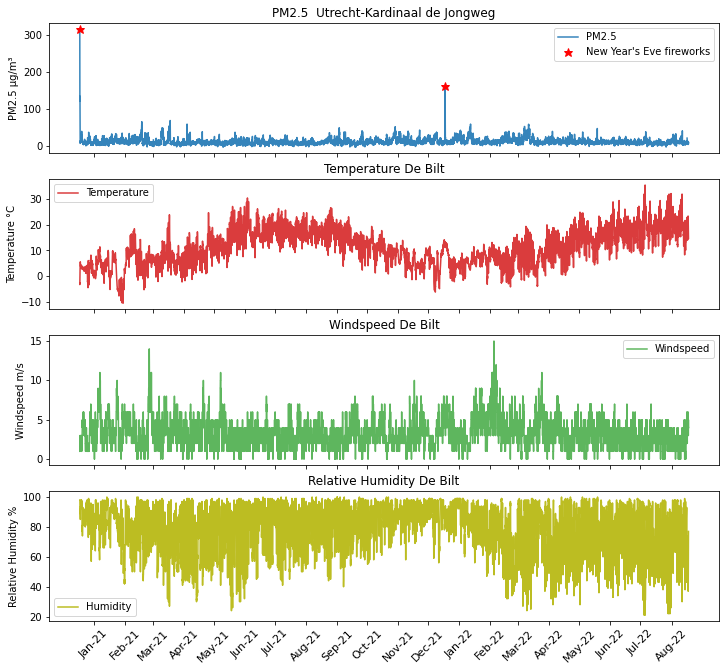

In [18]:
# PM2.5 and weather variables over time for daily averages
plot_weather(Utrecht_Kar_end, 'Date_Formal')

### 4.3 Heatmaps Pearson Correlations

In [19]:
# heatmaps pearson correlations
def plot_heatmaps(dfs):
    labels_heat = ['PM2.5', 'Temperature', 'Windspeed', 'Humidity']

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

    # pearson correlations
    df_group1 = dfs[0].loc[:, ['PM_25', 'Temp_c', 'Wind_ms', 'Humidity']]
    df_1cor = df_group1.corr()
    df_group2 = dfs[1].loc[:, ['PM_25', 'Temp_c', 'Wind_ms', 'Humidity']]
    df_2cor = df_group2.corr()
    df_group3 = dfs[2].loc[:, ['PM_25', 'Temp_c', 'Wind_ms', 'Humidity']]
    df_3cor = df_group3.corr()
    df_group4 = dfs[3].loc[:, ['PM_25', 'Temp_c', 'Wind_ms', 'Humidity']]
    df_4cor = df_group4.corr()

    # top left heatmap: Utrecht Kardinaal 
    sns.heatmap(ax=axes[0, 0], data=df_1cor, cmap='vlag', annot=True, xticklabels=labels_heat, yticklabels=labels_heat,
                cbar_kws={'label': 'Pearson Correlation'})
    axes[0, 0].set_title(stations_name[0], fontsize=13.6)

    # top right heatmap: Breukelen
    sns.heatmap(ax=axes[0, 1], data=df_2cor, cmap='vlag', annot=True, xticklabels=labels_heat, yticklabels=labels_heat,
                cbar_kws={'label': 'Pearson Correlation'})
    axes[0, 1].set_title(stations_name[1], fontsize=13.6)

    # left lower heatmap: Utrecht Griftpark
    sns.heatmap(ax=axes[1, 0], data=df_3cor, cmap='vlag', annot=True, xticklabels=labels_heat, yticklabels=labels_heat,
                cbar_kws={'label': 'Pearson Correlation'})
    axes[1, 0].set_title(stations_name[2], fontsize=13.6)

    # right lower heatmap: Cabauw
    sns.heatmap(ax=axes[1, 1], data=df_4cor, cmap='vlag', annot=True, xticklabels=labels_heat, yticklabels=labels_heat,
                cbar_kws={'label': 'Pearson Correlation'})
    axes[1, 1].set_title(stations_name[3], fontsize=13.6)

    plt.savefig(f'../Pictures/Output_More/EDA/heatmap_cor.jpg', dpi=600)
    plt.show()

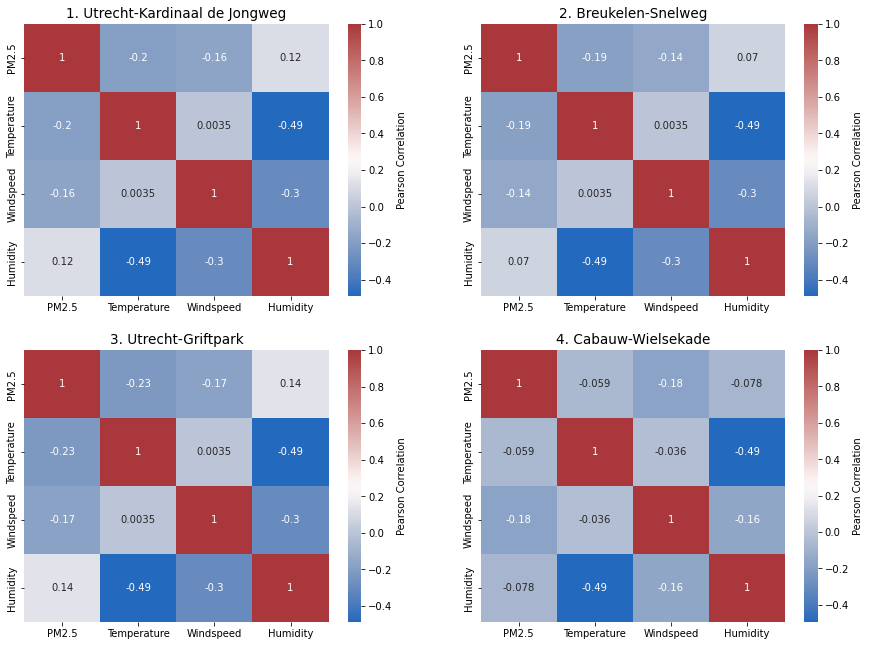

In [20]:
# plotting 4 heatmap correlations
plot_heatmaps(dfs_all)

### 4.4 Missing Values + Outlier Treatment

In [21]:
# linear interpolate the missing values of PM2.5 data and replace first three 'firework' values:
def missing_values_outliers(df):
    # 1 januari 2022: 3 hours missing values
    index_start = df[(df['Date']=='2022-01-01') & (df['Hour']=='00')].index[0]
    index_end = df[(df['Date']=='2022-01-01') & (df['Hour']=='02')].index[0]
    df.loc[index_start:index_end, "PM_25"] = np.nan
    df['PM_25'].interpolate(inplace=True)

    # 1 januari 2021 first 3 hours replacing to missing values
    df.loc[0:6, ['PM_25']] = np.nan
    df['PM_25'].bfill(inplace=True)
    return df

Utrecht_Kar_clean = missing_values_outliers(Utrecht_Kar_end)
Breukelen_clean = missing_values_outliers(Breukelen_end)
Utrecht_Gri_clean = missing_values_outliers(Utrecht_Gri_end)
Cabauw_clean = missing_values_outliers(Cabauw_end)

In [22]:
# no missing values left
print(f'Total amount missing values {stations_name[0][3:]}: {Utrecht_Kar_clean.isnull().values.sum()}')
print(f'Total amount missing values {stations_name[1][3:]}: {Breukelen_clean.isnull().values.sum()}')
print(f'Total amount missing values {stations_name[2][3:]}: {Utrecht_Gri_clean.isnull().values.sum()}')
print(f'Total amount missing values {stations_name[3][3:]}: {Cabauw_clean.isnull().values.sum()}')


Total amount missing values Utrecht-Kardinaal de Jongweg: 0
Total amount missing values Breukelen-Snelweg: 0
Total amount missing values Utrecht-Griftpark: 0
Total amount missing values Cabauw-Wielsekade: 0


## 5. Prepare Data for Training

### 5.1 Split the dataframes into Blocked Time-Series Split Cross Validation numpy arrays

In [23]:
# split data into blocks: 3 training 1 validation 1 testing
def blocked_timeseries_split(df, len_train, len_valid, len_test, multi):
    # splitting unique months
    unique_months = df['Month_unique'].unique()
    columns_multi = ['PM_25', 'Temp_c', 'Wind_ms', 'Humidity', 
                     'Month_cos', 'Month_sin', 'WeekDay_cos', 'WeekDay_sin', 'Hour_cos', 'Hour_sin']
    
    training_data = []
    validation_data = []
    test_data = []

    # amount blocks
    for i in range(0, len(unique_months) - len_train - len_valid - len_test + 1, len_test):
        # multivariate case: PM2.5 data, weather variables and seasonality
        if multi:
            # the training, validation and test blocks
            train = df.loc[df['Month_unique'].isin(unique_months[i:i+len_train]), columns_multi].to_numpy()
            valid = df.loc[df['Month_unique'].isin(unique_months[i+len_train: i+len_train+len_valid]), columns_multi].to_numpy()
            test  = df.loc[df['Month_unique'].isin(unique_months[i+len_train+len_valid : i+len_train+len_valid+len_test]), columns_multi].to_numpy()
            
        # univariate case: only PM2.5 data
        else:
            # the training, validation and test blocks
            train = df.loc[df['Month_unique'].isin(unique_months[i:i+len_train]), ['PM_25']].to_numpy()
            valid = df.loc[df['Month_unique'].isin(unique_months[i+len_train: i+len_train+len_valid]), ['PM_25']].to_numpy()
            test  = df.loc[df['Month_unique'].isin(unique_months[i+len_train+len_valid : i+len_train+len_valid+len_test]), ['PM_25']].to_numpy()

        training_data.append(train)
        validation_data.append(valid)
        test_data.append(test)

    return training_data, validation_data, test_data

In [24]:
# univariate cases
train_uni_Utrecht_Kar, val_uni_Utrecht_Kar, test_uni_Utrecht_Kar = blocked_timeseries_split(Utrecht_Kar_end, 6, 2, 2, False)
train_uni_Breukelen,   val_uni_Breukelen,   test_uni_Breukelen   = blocked_timeseries_split(Breukelen_end, 6, 2, 2, False)
train_uni_Utrecht_Gri, val_uni_Utrecht_Gri, test_uni_Utrecht_Gri = blocked_timeseries_split(Utrecht_Gri_end, 6, 2, 2, False)
train_uni_Cabauw,      val_uni_Cabauw,      test_uni_Cabauw      = blocked_timeseries_split(Cabauw_end, 6, 2, 2, False)

In [25]:
# multivariate cases
train_multi_Utrecht_Kar, val_multi_Utrecht_Kar, test_multi_Utrecht_Kar = blocked_timeseries_split(Utrecht_Kar_end, 6, 2, 2, True)
train_multi_Breukelen,   val_multi_Breukelen,   test_multi_Breukelen   = blocked_timeseries_split(Breukelen_end, 6, 2, 2, True)
train_multi_Utrecht_Gri, val_multi_Utrecht_Gri, test_multi_Utrecht_Gri = blocked_timeseries_split(Utrecht_Gri_end, 6, 2, 2, True)
train_multi_Cabauw,      val_multi_Cabauw,      test_multi_Cabauw      = blocked_timeseries_split(Cabauw_end, 6, 2, 2, True)

### 5.2 Classes voor Rolling window

In [26]:
# univariate time window class
class Time_Window_Uni():
    # input: t_steps back and forward and output dimension
    def __init__(self, t_back, t_forward, x_dim=3):
        self.t_back = t_back
        self.t_forward = t_forward - 1
        self.x_dim = x_dim

    # slicing over the data, expects data to slice
    def create_window(self, data):
        self.data = data
        
        x_values = []
        y_values = []

        # looping over data 
        for i in range(len(self.data) - self.t_back - self.t_forward):
            # create supervised learning
            x_values.append(self.data[i:i+self.t_back])
            y_values.append(self.data[i + self.t_back + self.t_forward])

        x_mat = np.array(x_values)
        y_mat = np.array(y_values)
        
        # reshaping for 2D matrix
        if self.x_dim == 2:
            return x_mat.reshape(x_mat.shape[0], x_mat.shape[1]), y_mat.reshape(y_mat.shape[0])
        
        # other wise: 3D matrix used for Keras
        return x_mat, y_mat

In [27]:
# multivariate time window class
class Time_Window_Multi():
    # input: data, t_steps back and forward and output dimension
    def __init__(self, t_back, t_forward, x_dim=3):
        self.t_back = t_back
        # t_forward - 1, because we go t_back in time so the first value next is already 1 hour ahead
        self.t_forward = t_forward - 1
        self.x_dim = x_dim

    # function to slice window for multivariate model, expects the data to slice
    def create_window(self, data):
        self.data = data

        x_values = []
        y_values = []

        # looping over data 
        for i in range(len(self.data) - self.t_back - self.t_forward):
            # create supervised learning problem
            x_values.append(self.data[i:i+self.t_back])
            y_values.append([self.data[i + self.t_back + self.t_forward][0]])

        x_mat = np.array(x_values)
        y_mat = np.array(y_values)
        
        # reshaping for 2D matrix
        if self.x_dim == 2:
            return x_mat.reshape(x_mat.shape[0], x_mat.shape[1]*x_mat.shape[2]), y_mat.reshape(y_mat.shape[0])
        
        # other wise: 3D x_values
        return x_mat, y_mat

## 6. Train Machine Learning Models

In [28]:
# Machine Learning models
from sklearn.linear_model import LinearRegression

# Deep Learning models 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.layers import Input, MultiHeadAttention, LayerNormalization, Add, Embedding, Flatten
from keras.models import Model
import tensorflow as tf

# sklearn error metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

# Table Representation
from tabulate import tabulate

### 6.0 Additional Functions for clean code

#### A. Error Analysis function

In [29]:
# MAE, RMSE and R2-score based on y_true and y_pred
def error_analysis(y_trues, y_preds):
    mae = mean_absolute_error(y_trues, y_preds)
    rmse = mean_squared_error(y_trues, y_preds, squared=False)
    r2 = r2_score(y_trues, y_preds)
    return mae, rmse, r2

#### B. Table Output Function

In [30]:
# fancy table out of error analysis
def create_table(output) -> list:
    # rounding errors
    for row in output:
        for i, val in enumerate(row):
            if i != 0:
                row[i] = round(val, 3)

    col_names = ['stations', 'MAE', 'RMSE', 'R2_score']
    return tabulate(output, headers=col_names, tablefmt="fancy_grid")

#### C. Min-Max Normalization function for 3D data

In [31]:
# min-max normalization data:
def min_max(train_x, val_x, test_x):

    # looping over the different features
    for feature in range(4):
        # max and min of specifc feature for training data
        train_max = np.max(train_x[:, :, feature])
        train_min = np.min(train_x[:, :, feature])

        # normalizing training, validation and test data with train max and min values
        train_x[:, :, feature] = (train_x[:, :, feature] - train_min) / (train_max - train_min)
        val_x[:, :, feature]   = (val_x[:, :, feature] - train_min) / (train_max - train_min)
        test_x[:, :, feature]  = (test_x[:, :, feature] - train_min) / (train_max - train_min)

    return train_x, val_x, test_x

#### D. Extra Necessary Variables

In [32]:
# lists of all univariate data
train_uni_all = [train_uni_Utrecht_Kar, train_uni_Breukelen, train_uni_Utrecht_Gri, train_uni_Cabauw]
val_uni_all      = [val_uni_Utrecht_Kar,   val_uni_Breukelen,   val_uni_Utrecht_Gri,   val_uni_Cabauw]
test_uni_all     = [test_uni_Utrecht_Kar,  test_uni_Breukelen,  test_uni_Utrecht_Gri,  test_uni_Cabauw]

In [33]:
# all multivariate data
train_multi_all = [train_multi_Utrecht_Kar, train_multi_Breukelen, train_multi_Utrecht_Gri, train_multi_Cabauw]
val_multi_all      = [val_multi_Utrecht_Kar,   val_multi_Breukelen,   val_multi_Utrecht_Gri,   val_multi_Cabauw]
test_multi_all     = [test_multi_Utrecht_Kar,  test_multi_Breukelen,  test_multi_Utrecht_Gri,  test_multi_Cabauw]

In [34]:
# the test-fold sizes
weights_test = [test.shape[0] for test in test_uni_Utrecht_Kar]
print(f'The test weights / sizes are {weights_test}')

The test weights / sizes are [1464, 1464, 1416, 1464, 1464, 1488]


### 6.1 The Models

#### A. Linear Regression / Baseline Model

In [35]:
""" function for linear regression / baseline model predictions """

# input: all uni train, val and test data, staions_names, timesteps forward and whether it's univariate or multivariate
def linear_regression(all_train, all_val, all_test, names, t_forward, multivariate=True):

    final_output_linear = []

    # looping over the 4 different locations
    for i in range(len(all_train)):
        
        # all MAE, RMSE, R2-scores for one location corrected for different fold sizes
        all_mae_lin = []
        all_rmse_lin = []
        all_r2_lin = []

        # looping over de different folds of 1 location
        for train_one, val_one, test_one in zip(all_train[i], all_val[i], all_test[i]):

            # mutlivariate case: PM2.5 data and weather data
            if multivariate:
                # create x, y of multivariate training data
                window_train = Time_Window_Multi(24, t_forward, x_dim=2)
                x_train_lin, y_train_lin = window_train.create_window(train_one)

                # create x, y of multivariate validation data
                window_val = Time_Window_Multi(24, t_forward, x_dim=2)
                x_val_lin, y_val_lin = window_val.create_window(val_one)

                # create x, y of multivariate test data
                window_test = Time_Window_Multi(24, t_forward, x_dim=2)
                x_test_lin, y_test_lin = window_test.create_window(test_one)
            
            # univariate case: only PM2.5 data
            else:
                # create x, y of univariate training data
                window_train = Time_Window_Uni(24, t_forward, x_dim=2)
                x_train_lin, y_train_lin = window_train.create_window(train_one)

                # create x, y of univariate validation data       
                window_val = Time_Window_Uni(24, t_forward, x_dim=2)
                x_val_lin, y_val_lin = window_val.create_window(val_one)

                # create x, y of univariate test data       
                window_test = Time_Window_Uni(24, t_forward, x_dim=2)
                x_test_lin, y_test_lin = window_test.create_window(test_one)

            # combining test and validation data: no hyperparameters for basic linear regession!
            x_train_full_lin = np.vstack((x_train_lin, x_val_lin))
            y_train_full_lin = np.append(y_train_lin, y_val_lin)


            """ Create Linear Model to predict test data """
            
            lin_model = LinearRegression()
            lin_model.fit(x_train_full_lin, y_train_full_lin)
            # predictions on test data
            y_test_lin_pred = lin_model.predict(x_test_lin)

            # error analysis on test data
            mae_lin, rmse_lin, r2_lin = error_analysis(y_test_lin, y_test_lin_pred)
            # appending to the lists
            all_mae_lin.append(mae_lin)
            all_rmse_lin.append(rmse_lin)
            all_r2_lin.append(r2_lin)

        # weighted averages of MAE, RMSE and R2-score using the sizes of the test folds
        weighted_mae = np.average(all_mae_lin, weights=weights_test)
        weighted_rmse = np.average(all_rmse_lin, weights=weights_test)
        weighted_r2 = np.average(all_r2_lin, weights=weights_test)

        final_output_linear.append([names[i], weighted_mae, weighted_rmse, weighted_r2])

    # mean values of the 4 different locations
    final_output_linear.append(['Mean Values', np.mean([x[1] for x in final_output_linear]), 
                np.mean([x[2] for x in final_output_linear]), np.mean([x[3] for x in final_output_linear])])

    # returning a nice output table of the results and the list of values, including mean values
    output_table = create_table(final_output_linear)
    return output_table, final_output_linear

#### B. LSTM Model

In [36]:
# LSTM model with hyperparameters for grid search
def lstm_model(input_shapes, n_lstm, drop_rate):
    model = Sequential()
    # first LSTM block
    model.add(LSTM(n_lstm, input_shape = input_shapes, activation='relu', return_sequences=True))
    model.add(Dropout(drop_rate))
    # second LSTM block
    model.add(LSTM(n_lstm, activation='relu'))
    model.add(Dropout(drop_rate))
    # outcome layer
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae', 'mse'])
    return model

In [122]:
""" Function for LSTM model predictions """

# input: all uni train, val and test data, staions_names, timesteps forward and whether it's univariate or multivariate
def lstm(all_train, all_val, all_test, names, t_forward, multivariate=True):

    final_output_lstm = []

    # looping over the 4 different locations
    for i in range(len(all_train)):

        # all MAE, RMSE, R2-scores for one location based on the different folds
        all_mae_lstm = []
        all_rmse_lstm = []
        all_r2_lstm = []

        # looping over de different folds of 1 location
        for train_one, val_one, test_one in zip(all_train[i], all_val[i], all_test[i]):

            # multivariate case:
            if multivariate:
                # hyperparamters 
                t_back = 2
                epoch = 30
                batches = [32, 64]
                drops = [0.1, 0.16, 0.22]
                num_lstm = [16, 32]

                # create x, y of multivariate 3D training data
                window_train = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_train_lstm, y_train_lstm = window_train.create_window(train_one)

                # create x, y of multivariate 3D validation data
                window_val = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_val_lstm, y_val_lstm = window_val.create_window(val_one)

                # create x, y of multivariate 3D test data
                window_test = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_test_lstm, y_test_lstm = window_test.create_window(test_one)

                # normalize all x values using the defined min-max normalizer function
                x_train_lstm, x_val_lstm, x_test_lstm = min_max(x_train_lstm, x_val_lstm, x_test_lstm)

                # input shape multivariate
                input_shape = (t_back, x_train_lstm.shape[2])
        
            # univariate case
            else:
                # hyperparameters
                t_back = 24
                epoch = 19
                batches = [64, 128]
                drops = [0.1, 0.2]
                num_lstm = [16, 32]

                # create x, y of univariate 3D training data
                window_train = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_train_lstm, y_train_lstm = window_train.create_window(train_one)

                # create x, y of univariate 3D validation data
                window_val = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_val_lstm, y_val_lstm = window_val.create_window(val_one)

                # create x, y of univariate 3D test data
                window_test = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_test_lstm, y_test_lstm = window_test.create_window(test_one)

                # input shape univariate
                input_shape = (t_back, 1)

            """ Grid Search """
            # validation R2, for hyperparameter tuning:
            val_r2 = []
            grid_search = []

            # looping over the competitive LSTM parameters
            for n_lstm in num_lstm:
                for drop in drops:
                    for bat in batches:

                        # model given input shape, amount lstm and drop-out rate
                        model = lstm_model(input_shape, n_lstm, drop)

                        # fitting specific model to training data 
                        history = model.fit(x_train_lstm, y_train_lstm, epochs=epoch-3, batch_size=bat, verbose=0)

                        # predicting validation values
                        y_val_lstm_pred = model.predict(x_val_lstm)
                        # error analysis on validation data to select best performing model
                        _, _, r2_lstm = error_analysis(y_val_lstm, y_val_lstm_pred)
                        
                        # use rmse validation as measure to see which competitive model is best
                        val_r2.append(r2_lstm)
                        grid_search.append([n_lstm, drop, bat])


            """ Train Best Model """

            # which set op parameters has highest r2 on validation data = winning model
            high_r2 = val_r2.index(max(val_r2))            
            winning_model = lstm_model(input_shape, grid_search[high_r2][0], grid_search[high_r2][1])

            # the full training data = train + validation data, used to fit best model on!
            x_train_full_lstm = np.vstack((x_train_lstm, x_val_lstm))
            y_train_full_lstm = np.vstack((y_train_lstm, y_val_lstm))

            # fit winning model onto training + validation
            history = winning_model.fit(x_train_full_lstm, y_train_full_lstm, epochs=epoch, 
                                        batch_size=grid_search[high_r2][2], verbose=0)

            # predicting test values and error analysis on values
            y_test_lstm_pred = winning_model.predict(x_test_lstm)
            mae_lstm, rmse_lstm, r2_lstm = error_analysis(y_test_lstm, y_test_lstm_pred)

            # the test errors to lists
            all_mae_lstm.append(mae_lstm)
            all_rmse_lstm.append(rmse_lstm)
            all_r2_lstm.append(r2_lstm)        

        # weighted averages of MAE, RMSE and R2-score using the sizes of the folds
        weighted_mae = np.average(all_mae_lstm, weights=weights_test)
        weighted_rmse = np.average(all_rmse_lstm, weights=weights_test)
        weighted_r2 = np.average(all_r2_lstm, weights=weights_test)

        final_output_lstm.append([names[i], weighted_mae, weighted_rmse, weighted_r2])

    # mean values of the 4 different locations
    final_output_lstm.append(['Mean Values', np.mean([x[1] for x in final_output_lstm]), 
                np.mean([x[2] for x in final_output_lstm]), np.mean([x[3] for x in final_output_lstm])])
    
    # returning a nice output table of the results
    output_table = create_table(final_output_lstm)
    return output_table, final_output_lstm

#### C. Transformer Model

In [38]:
def positional_encoding(inputs, position):
    angle_rads = 1 / np.power(10000, (2 * (position[:, np.newaxis]) // 2) / np.float32(inputs.shape[1]))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(inputs + pos_encoding, tf.float32)

# transformer univariate model with grid search parameters
def trans_uni_model(input_shape, n_trans, drop_rate):
    inputs = Input(shape=input_shape)

    # positional encoding
    x = positional_encoding(inputs, tf.range(start=0, limit=input_shape[1], delta=1))

    # transformer encoder layers
    encoder_layer1 = MultiHeadAttention(num_heads=8, key_dim=1, name='encoder_attention')
    encoder_layer2 = Dense(units=n_trans, activation='relu', name='encoder_dense1')
    encoder_layer3 = Dropout(drop_rate, name='encoder_dropout')

    # transformer decoder layers
    decoder_layer1 = Dense(units=n_trans, activation='relu', name='decoder_dense1')
    decoder_layer2 = Dropout(drop_rate, name='decoder_dropout')
    decoder_layer3 = Dense(units=1, name='decoder_dense2')

    # encoder block 1
    x = encoder_layer1(x, x)
    x = Flatten()(x)
    x = encoder_layer2(x)
    x = encoder_layer3(x)

    # decoder block 1
    x = decoder_layer1(x)
    x = decoder_layer2(x)
    outputs = decoder_layer3(x)

    # create model and compiling it
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

In [39]:
# transformer multivariate model with grid search parameters
def trans_multi_model(input_shape, n_trans, drop_rate):
    inputs = Input(shape=input_shape)

    # transformer encoder layers
    encoder_layer1 = MultiHeadAttention(num_heads=16, key_dim=1, name='encoder_attention')
    encoder_layer2 = Dense(units=n_trans, activation='relu', name='encoder_dense1')
    encoder_layer3 = Dropout(drop_rate, name='encoder_dropout')

    # transformer decoder layers
    decoder_layer1 = Dense(units=n_trans, activation='relu', name='decoder_dense1')
    decoder_layer2 = Dropout(drop_rate, name='decoder_dropout')
    decoder_layer3 = Dense(units=1, name='decoder_dense2')

    # encoder block 1
    x = encoder_layer1(inputs, inputs)
    x = Flatten()(x)
    x = encoder_layer2(x)
    x = encoder_layer3(x)

    # decoder block 1
    x = decoder_layer1(x)
    x = decoder_layer2(x)
    outputs = decoder_layer3(x)

    # create model and compiling it
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics = ['mae', 'mse'])
    return model

In [40]:
""" function for Transformer predictions """

# input: all uni train, val and test data, staions_names, timesteps forward and whether it's univariate or multivariate
def transformer(all_train, all_val, all_test, names, t_forward, multivariate=True):

    final_output_trans = []

    # looping over the 4 different locations
    for i in range(len(all_train)):

        # all MAE, RMSE, R2-scores for one location based on the different folds
        all_mae_trans = []
        all_rmse_trans = []
        all_r2_trans = []

        # looping over de different folds of 1 location
        for train_one, val_one, test_one in zip(all_train[i], all_val[i], all_test[i]):

            # multivariate case:
            if multivariate:
                t_back = 2

                # create x, y of multivariate 3D training data
                window_train = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_train_trans, y_train_trans = window_train.create_window(train_one)

                # create x, y of multivariate 3D validation data
                window_val = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_val_trans, y_val_trans = window_val.create_window(val_one)

                # create x, y of multivariate 3D test data
                window_test = Time_Window_Multi(t_back, t_forward, x_dim=3)
                x_test_trans, y_test_trans = window_test.create_window(test_one)

                # normalize all x values using the defined min-max normalizer function
                x_train_trans, x_val_trans, x_test_trans = min_max(x_train_trans, x_val_trans, x_test_trans)
                
                # multivariate input shpae
                input_shape = (t_back, x_train_trans.shape[2])
        
            # univariate case
            else:
                t_back = 24

                # create x, y of univariate 3D training data
                window_train = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_train_trans, y_train_trans = window_train.create_window(train_one)

                # create x, y of univariate 3D validation data
                window_val = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_val_trans, y_val_trans = window_val.create_window(val_one)

                # create x, y of univariate 3D test data
                window_test = Time_Window_Uni(t_back, t_forward, x_dim=3)
                x_test_trans, y_test_trans = window_test.create_window(test_one)

                # univariate input shape
                input_shape = (t_back, 1)


            """ Grid Search """
            # validation R2-scores, for hyperparameter tuning:
            val_r2 = []
            grid_search = []

            # looping over the competitive Transformer models
            for n_trans in [16, 32, 64]:
                for drop_rate in [0.1, 0.2]:

                    # fitting model for grid serach
                    if multivariate:
                        model = trans_multi_model(input_shape, n_trans, drop_rate)
                    else:
                        model = trans_uni_model(input_shape, n_trans, drop_rate)

                    # fitting specific model to training data 
                    history = model.fit(x_train_trans, y_train_trans, epochs=30, batch_size=64, verbose=0)

                    # predicting validation values
                    y_val_trans_pred = model.predict(x_val_trans)
                    # error analysis on validation data to select best performing model
                    _, _, r2_trans = error_analysis(y_val_trans, y_val_trans_pred)
                    # use r2 validation as measure to see which competitive model is best
                    val_r2.append(r2_trans)
                    grid_search.append([n_trans, drop_rate])


            """ Train Best Model """

            # which model has highest r2 on validation data = winning model
            high_r2 = val_r2.index(max(val_r2))
            
            # winning model with best parameters of grid search
            if multivariate:
                winning_model = trans_multi_model(input_shape, grid_search[high_r2][0], grid_search[high_r2][1])
            else:
                winning_model = trans_uni_model(input_shape, grid_search[high_r2][0], grid_search[high_r2][1])

            # the full training data = train + validation data, used to fit best model on
            x_train_full_trans = np.vstack((x_train_trans, x_val_trans))
            y_train_full_trans = np.vstack((y_train_trans, y_val_trans))

            # fit winning model onto training + validation
            history = winning_model.fit(x_train_full_trans, y_train_full_trans, epochs=35, batch_size=64, verbose=0)

            # predicting test values and error analysis on values 
            y_test_trans_pred = winning_model.predict(x_test_trans)
            mae_trans, rmse_trans, r2_trans = error_analysis(y_test_trans, y_test_trans_pred)

            # the test errors to lists
            all_mae_trans.append(mae_trans)
            all_rmse_trans.append(rmse_trans)
            all_r2_trans.append(r2_trans)        

        # weighted averages of MAE, RMSE and R2-score using the sizes of the folds
        weighted_mae = np.average(all_mae_trans, weights=weights_test)
        weighted_rmse = np.average(all_rmse_trans, weights=weights_test)
        weighted_r2 = np.average(all_r2_trans, weights=weights_test)

        final_output_trans.append([names[i], weighted_mae, weighted_rmse, weighted_r2])

    # mean values of the 4 different locations
    final_output_trans.append(['Mean Values', np.mean([x[1] for x in final_output_trans]), 
                np.mean([x[2] for x in final_output_trans]), np.mean([x[3] for x in final_output_trans])])
    
    # returning a nice output table of the results
    output_table = create_table(final_output_trans)
    return output_table, final_output_trans

### 6.2 Results Univariate

#### A. Linear Regression Univariate

In [41]:
# calling the linear regression / baseline model for all locations, predicting 1 hour ahead
table_lin_uni_1, out_lin_uni_1 = linear_regression(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=1, multivariate=False) 

print('Results univariate Linear Regression Model for Predicting 1 Hour Ahead:')   
print(table_lin_uni_1)

Results univariate Linear Regression Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 2.672 │  3.536 │      0.713 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.569 │  3.474 │      0.739 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 2.682 │  3.599 │      0.698 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 2.739 │  3.739 │      0.748 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 2.665 │  3.587 │      0.724 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [42]:
# calling the linear regression / baseline model for all locations, predicting 4 hours ahead
table_lin_uni_4, out_lin_uni_4 = linear_regression(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=4, multivariate=False) 

print('Results univariate Linear Regression Model for Predicting 4 Hours Ahead:')   
print(table_lin_uni_4)

Results univariate Linear Regression Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.845 │  5.17  │      0.414 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 3.855 │  5.289 │      0.42  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 3.856 │  5.209 │      0.397 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.431 │  5.891 │      0.38  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 3.997 │  5.39  │      0.403 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [43]:
# calling the linear regression / baseline model for all locations, predicting 12 hours ahead
table_lin_uni_12, out_lin_uni_12 = linear_regression(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=12, multivariate=False) 

print('Results univariate Linear Regression Model for Predicting 12 Hours Ahead:')   
print(table_lin_uni_12)

Results univariate Linear Regression Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.736 │  6.5   │      0.133 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.778 │  6.563 │      0.144 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.796 │  6.447 │      0.13  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 5.232 │  6.967 │      0.166 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.885 │  6.619 │      0.143 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


#### B. LSTM Univariate

In [44]:
# LSTM univariate 1 hour ahead
table_lstm_uni_1, out_lstm_uni_1 = lstm(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=1, multivariate=False)

46/46 [==============================] - 1s 10ms/step


In [45]:
print('Results univariate LSTM Model for Predicting 1 Hour Ahead:')   
print(table_lstm_uni_1)

Results univariate LSTM Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.001 │  4.054 │      0.652 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.609 │  3.587 │      0.728 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 2.789 │  3.804 │      0.679 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 2.841 │  3.913 │      0.731 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 2.81  │  3.839 │      0.698 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [46]:
# LSTM univariate 4 hours ahead
table_lstm_uni_4, out_lstm_uni_4 = lstm(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=4, multivariate=False)

46/46 [==============================] - 1s 8ms/step


In [47]:
print('Results univariate LSTM Model for Predicting 4 Hours Ahead:')   
print(table_lstm_uni_4)

Results univariate LSTM Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.899 │  5.415 │      0.381 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.068 │  5.64  │      0.347 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 3.909 │  5.393 │      0.378 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.473 │  6.117 │      0.35  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.087 │  5.641 │      0.364 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [48]:
# LSTM univariate 12 hours ahead
table_lstm_uni_12, out_lstm_uni_12 = lstm(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=12, multivariate=False)

46/46 [==============================] - 2s 8ms/step


In [49]:
print('Results univariate LSTM Model for Predicting 12 Hours Ahead:')   
print(table_lstm_uni_12)

Results univariate LSTM Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.847 │  6.775 │      0.083 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.777 │  6.699 │      0.133 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.831 │  6.681 │      0.095 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 5.37  │  7.222 │      0.119 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.956 │  6.844 │      0.108 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


#### C. Transformer Univariate

In [50]:
# Transformer univariate 1 hour ahead
table_trans_uni_1, out_trans_uni_1 = transformer(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=1, multivariate=False)

46/46 [==============================] - 0s 4ms/step


In [51]:
print('Results univariate Transformer Model for Predicting 1 Hour Ahead:')   
print(table_trans_uni_1)

Results univariate Transformer Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.123 │  4.24  │      0.608 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.884 │  3.938 │      0.671 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 3.08  │  4.157 │      0.623 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 3.207 │  4.409 │      0.667 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 3.073 │  4.186 │      0.642 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [52]:
# Transformer univariate 4 hours ahead
table_trans_uni_4, out_trans_uni_4 = transformer(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=4, multivariate=False)

46/46 [==============================] - 1s 7ms/step


In [53]:
print('Results univariate Transformer Model for Predicting 4 Hours Ahead:')   
print(table_trans_uni_4)

Results univariate Transformer Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.983 │  5.444 │      0.365 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.102 │  5.619 │      0.351 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.132 │  5.586 │      0.333 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.631 │  6.212 │      0.324 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.212 │  5.715 │      0.343 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [54]:
# Transformer univariate 12 hours ahead
table_trans_uni_12, out_trans_uni_12 = transformer(train_uni_all, val_uni_all, test_uni_all, stations_name, t_forward=12, multivariate=False)

46/46 [==============================] - 0s 6ms/step


In [55]:
print('Results univariate Transformer Model for Predicting 12 Hours Ahead:')   
print(table_trans_uni_12)

Results univariate Transformer Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.791 │  6.533 │      0.137 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.831 │  6.683 │      0.127 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.969 │  6.771 │      0.076 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 5.43  │  7.481 │      0.073 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 5.005 │  6.867 │      0.103 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


### 6.3 Results Multivariate

#### A. Linear Regression Multivariate

In [56]:
# linear regression / baseline model for all locations, predicting 1 hour ahead
table_lin_multi_1, out_lin_multi_1 = linear_regression(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=1, multivariate=True) 

print('Results Multivariate Linear Regression Model for Predicting 1 Hour Ahead:')   
print(table_lin_multi_1)

Results Multivariate Linear Regression Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 2.658 │  3.51  │      0.714 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.582 │  3.473 │      0.738 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 2.679 │  3.572 │      0.702 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 2.687 │  3.638 │      0.762 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 2.651 │  3.548 │      0.729 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [57]:
# linear regression / baseline model for all locations, predicting 4 hours ahead
table_lin_multi_4, out_lin_multi_4 = linear_regression(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=4, multivariate=True) 

print('Results Multivariate Linear Regression Model for Predicting 4 Hours Ahead:')   
print(table_lin_multi_4)

Results Multivariate Linear Regression Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.756 │  4.996 │      0.44  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 3.783 │  5.144 │      0.446 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 3.727 │  4.982 │      0.446 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.135 │  5.456 │      0.471 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 3.85  │  5.144 │      0.451 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [58]:
# linear regression / baseline model for all locations, predicting 12 hours ahead
table_lin_multi_12, out_lin_multi_12 = linear_regression(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=12, multivariate=True) 

print('Results Multivariate Linear Regression Model for Predicting 12 Hours Ahead:')   
print(table_lin_multi_12)

Results Multivariate Linear Regression Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.594 │  6.159 │      0.204 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.62  │  6.249 │      0.215 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.579 │  6.079 │      0.214 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.912 │  6.384 │      0.301 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.676 │  6.218 │      0.234 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


#### B. LSTM Multivariate

In [59]:
# LSTM multivariate 1 hour 
table_lstm_multi_1, out_lstm_multi_1 = lstm(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=1, multivariate=True)

47/47 [==============================] - 1s 5ms/step


In [60]:
print('Results multivariate LSTM Model for Predicting 1 Hour Ahead:')   
print(table_lstm_multi_1)

Results multivariate LSTM Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 2.856 │  3.75  │      0.675 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.758 │  3.685 │      0.702 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 2.918 │  3.854 │      0.649 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 2.832 │  3.795 │      0.738 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 2.841 │  3.771 │      0.691 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [115]:
# LSTM multivariate 4 hours ahead
table_lstm_multi_4, out_lstm_multi_4 = lstm(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=4, multivariate=True)

47/47 [==============================] - 1s 7ms/step


In [116]:
print('Results multivariate LSTM Model for Predicting 4 Hours Ahead:')   
print(table_lstm_multi_4)

Results multivariate LSTM Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.059 │  5.512 │      0.338 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.089 │  5.634 │      0.35  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.327 │  5.767 │      0.259 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.528 │  6.028 │      0.367 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.251 │  5.735 │      0.328 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [123]:
# LSTM multivariate 12 hours ahead
table_lstm_multi_12, out_lstm_multi_12 = lstm(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=12, multivariate=True)

47/47 [==============================] - 1s 8ms/step


In [124]:
print('Results multivariate LSTM Model for Predicting 12 Hours Ahead:')   
print(table_lstm_multi_12)

Results multivariate LSTM Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.724 │  6.527 │      0.124 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.947 │  6.89  │      0.068 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 5.012 │  6.718 │      0.049 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 5.18  │  6.997 │      0.171 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.966 │  6.783 │      0.103 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


#### C. Transformer Multivariate

In [72]:
# Transformer multivariate 1 hour ahead
table_trans_multi_1, out_trans_multi_1 = transformer(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=1, multivariate=True)

47/47 [==============================] - 0s 3ms/step


In [73]:
print('Results multivariate Transformer Model for Predicting 1 Hour Ahead:')   
print(table_trans_multi_1)

Results multivariate Transformer Model for Predicting 1 Hour Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 2.697 │  3.581 │      0.706 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 2.689 │  3.59  │      0.719 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 2.725 │  3.66  │      0.687 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 2.763 │  3.744 │      0.748 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 2.718 │  3.644 │      0.715 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [74]:
# Transformer multivariate 4 hours ahead
table_trans_multi_4, out_trans_multi_4 = transformer(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=4, multivariate=True)

47/47 [==============================] - 0s 3ms/step


In [75]:
print('Results multivariate Transformer Model for Predicting 4 Hours Ahead:')   
print(table_trans_multi_4)

Results multivariate Transformer Model for Predicting 4 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 3.777 │  5.113 │      0.426 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 3.788 │  5.229 │      0.43  │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 3.976 │  5.29  │      0.394 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 4.212 │  5.657 │      0.438 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 3.938 │  5.322 │      0.422 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


In [94]:
# Transformer multivariate 12 hours ahead
table_trans_multi_12, out_trans_multi_12 = transformer(train_multi_all, val_multi_all, test_multi_all, stations_name, t_forward=12, multivariate=True)

47/47 [==============================] - 0s 5ms/step


In [77]:
print('Results multivariate Transformer Model for Predicting 12 Hours Ahead:')   
print(table_trans_multi_12)

Results multivariate Transformer Model for Predicting 12 Hours Ahead:
╒═════════════════════════════════╤═══════╤════════╤════════════╕
│ stations                        │   MAE │   RMSE │   R2_score │
╞═════════════════════════════════╪═══════╪════════╪════════════╡
│ 1. Utrecht-Kardinaal de Jongweg │ 4.696 │  6.46  │      0.137 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 2. Breukelen-Snelweg            │ 4.96  │  6.826 │      0.037 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 3. Utrecht-Griftpark            │ 4.516 │  6.154 │      0.224 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ 4. Cabauw-Wielsekade            │ 5.161 │  6.95  │      0.187 │
├─────────────────────────────────┼───────┼────────┼────────────┤
│ Mean Values                     │ 4.833 │  6.598 │      0.146 │
╘═════════════════════════════════╧═══════╧════════╧════════════╛


### 6.4 Summary plots results

In [125]:
# combining all model outputs
output_lin_all = [out_lin_uni_1, out_lin_multi_1, out_lin_uni_4, out_lin_multi_4, out_lin_uni_12, out_lin_multi_12]
output_lstm_all = [out_lstm_uni_1, out_lstm_multi_1, out_lstm_uni_4, out_lstm_multi_4, out_lstm_uni_12, out_lstm_multi_12]
output_trans_all = [out_trans_uni_1, out_trans_multi_1, out_trans_uni_4, out_trans_multi_4, out_trans_uni_12, out_trans_multi_12]

In [126]:
# MAE and RMSE of one model: linear regression, LSTM or Transformer
def mae_rmse_results_one(output_model_all, model, size, lower):
    # labels for plot
    labels = [f'{model}: Univariate 1 Hour',   f'{model}: Multivariate 1 Hour', 
              f'{model}: Univariate 4 Hours',  f'{model}: Multivariate 4 Hours', 
              f'{model}: Univariate 12 Hours', f'{model}: Multivariate 12 Hours']
    # colors used
    color = ['lightcoral', 'red', 'greenyellow', 'green', 'lightskyblue', 'mediumblue']
    # to indicate the location 
    texts = ['1.', '2.', '3.', '4.']

    # increase plot size:
    plt.figure(figsize=(9,6))

    # looping over the results for the models
    for i, output_one in enumerate(output_model_all):

        # all 4 MAE and RSME of one specific location
        plt.scatter([row[1] for row in output_one[:4]], [row[2] for row in output_one[:4]], 
                    label=labels[i], color=color[i], s=size, alpha=0.8)
        # adding text at correct location
        for j, rows in enumerate(output_one[:4]):
            plt.text(rows[1], rows[2]-lower, texts[j])

    # finalyzing layout
    plt.legend()
    plt.grid('True', linestyle='dashed')
    plt.xlabel('MAE')
    plt.ylabel('RMSE')
    plt.title(f'{model}: MAE vs RMSE')
    plt.savefig(f'../Pictures/Output_More/Results_mae_rmse_{model}.jpg', dpi=600)
    plt.show()

In [127]:
# Bar chart R2 score: Linear Regression, LSTM or Transformer
def r2_results_one(output_model_all, model):
    # labels for plot
    labels = [f'{model}: Univariate 1 Hour',   f'{model}: Multivariate 1 Hour', 
              f'{model}: Univariate 4 Hours',  f'{model}: Multivariate 4 Hours', 
              f'{model}: Univariate 12 Hours', f'{model}: Multivariate 12 Hours']
    # colors used
    color = ['lightcoral', 'red', 'greenyellow', 'green', 'lightskyblue', 'mediumblue']
    # to indicate the location 
    texts = ['1.', '2.', '3.', '4.']

    # increase plot size:
    plt.figure(figsize=(9,6))
    plt.grid('True', zorder=0, axis='y', linestyle='dashed')

    j = 0
    # 3 time periods groups:
    for i in range(3):
        # univariate specific time period
        plt.bar([i-0.2, i, i+0.2, i+0.4], [row[3] for row in output_model_all[j][:4]], width=0.08,
                    label=labels[j], color=color[j], alpha=0.8, zorder=3)
        j += 1

        # multivariate specific time period
        plt.bar([i-0.12, i+0.08, i+0.28, i+0.48], [row[3] for row in output_model_all[j][:4]], width=0.08,
                    label=labels[j], color=color[j], alpha=0.8, zorder=3)
        j += 1

    # finalyzing layout
    plt.legend()
    plt.xticks([-0.16, 0.04, 0.24, 0.44, 0.84, 1.04, 1.24, 1.44, 1.84, 2.04, 2.24, 2.44], texts+texts+texts)
    plt.xlabel('Location')
    plt.ylim(0,1)
    plt.yticks([x for x in np.arange(0, 1.01, 0.1)])
    plt.ylabel('R2')
    plt.title(f'{model}: R2 scores')
    plt.savefig(f'../Pictures/Output_More/Results_r2_{model}.jpg', dpi=600)
    plt.show()

#### A. Linear Regression / Baseline Model Plot Results

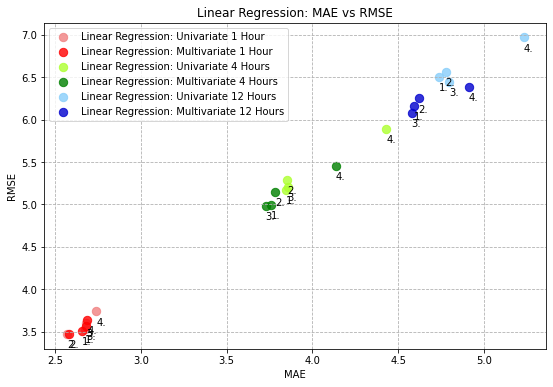

In [128]:
# MAE vs RMSE: Linear Regression results 
mae_rmse_results_one(output_lin_all, model='Linear Regression', size=70, lower=0.16)

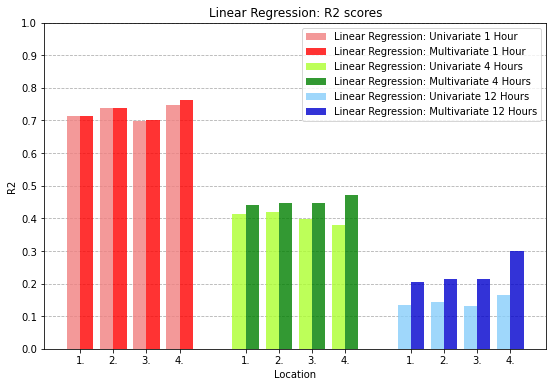

In [129]:
# R2-scores linear regression results
r2_results_one(output_lin_all, model='Linear Regression')

#### B. LSTM Model Plot Results

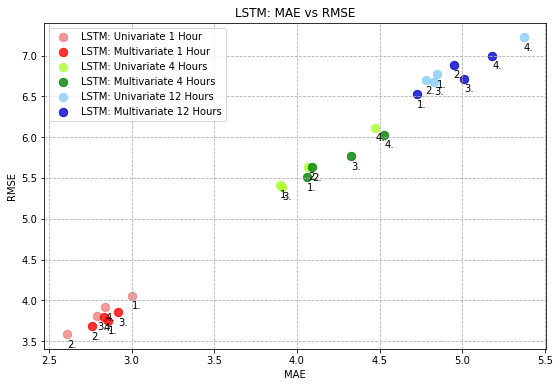

In [130]:
# MAE vs RMSE: LSTM results 
mae_rmse_results_one(output_lstm_all, model='LSTM', size=70, lower=0.16)

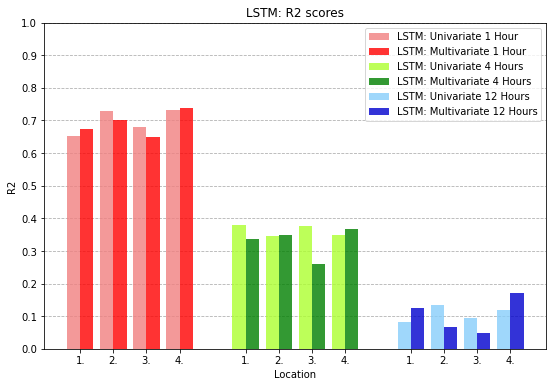

In [131]:
# R2-scores LSTM results 
r2_results_one(output_lstm_all, model='LSTM')

#### C. Transformer Model Plot Results

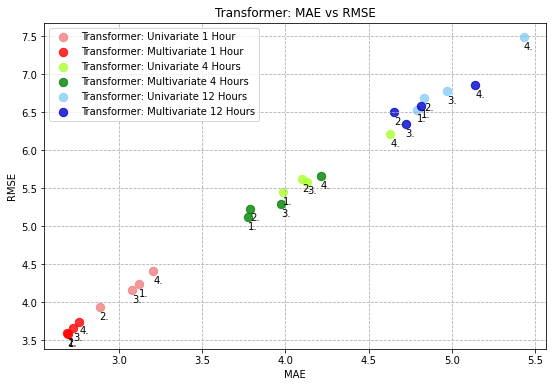

In [132]:
# MAE vs RMSE: Transformer results 
mae_rmse_results_one(output_trans_all, model='Transformer', size=70, lower=0.16)

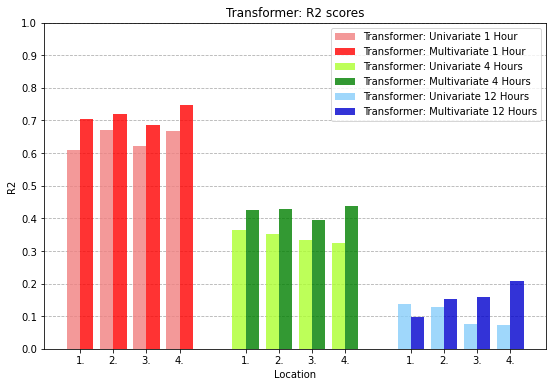

In [133]:
# R2-scores Transformer results
r2_results_one(output_trans_all, model='Transformer')

#### D. All Average Plot Results for Final Summary Thesis

In [134]:
# show mean MEA and RMSE of the 4 locations for all different models that have been tested
def mae_rmse_results_all(lin, lstm, trans, size, lower, font_size):
    
    color_lin = ['lightskyblue', 'mediumblue', 'lightskyblue', 'mediumblue', 'lightskyblue', 'mediumblue']
    color_lstm = ['greenyellow', 'green', 'greenyellow', 'green', 'greenyellow', 'green']
    color_trans = ['lightcoral', 'red', 'lightcoral', 'red', 'lightcoral', 'red']

    labels_lin = ['Linear Regression Univariate', 'Linear Regression Multivariate']
    labels_lstm = ['LSTM Univariate', 'LSTM Multivariate']
    labels_trans = ['Transformer Univariate', 'Transformer Multivariate']

    # labels time period
    time = [r'$t_{1.}$', r'$t_{1.}$', r'$t_{4.}$', r'$t_{4.}$', r'$t_{12.}$', r'$t_{12.}$']
    
    plt.figure(figsize=(9,6))

    # final Linear Regression Results
    for i, out_lin in enumerate(lin):
        # first univariate lin regression result
        if i == 0:
            plt.scatter(out_lin[-1][1], out_lin[-1][2], color=color_lin[i], label=labels_lin[0], alpha=0.7, s=size)
            plt.text(out_lin[-1][1], out_lin[-1][2]-lower, time[i], fontsize=font_size)
        # first multivariate lin regression result
        elif i == 1: 
            plt.scatter(out_lin[-1][1], out_lin[-1][2], color=color_lin[i], label=labels_lin[1], alpha=0.7, s=size)  
            plt.text(out_lin[-1][1], out_lin[-1][2]-lower, time[i], fontsize=font_size)   
        # no label
        else:   
            plt.scatter(out_lin[-1][1], out_lin[-1][2], color=color_lin[i], alpha=0.7, s=size)
            plt.text(out_lin[-1][1], out_lin[-1][2]-lower, time[i], fontsize=font_size)   

    # final LSTM results
    for j, out_lstm in enumerate(lstm):
        # first univariate lstm result
        if j == 0:
            plt.scatter(out_lstm[-1][1], out_lstm[-1][2], color=color_lstm[j], label=labels_lstm[0], alpha=0.7, s=size)
            plt.text(out_lstm[-1][1], out_lstm[-1][2]-lower, time[j], fontsize=font_size)
        # first multivariate lstm result
        elif j == 1:
            plt.scatter(out_lstm[-1][1], out_lstm[-1][2], color=color_lstm[j], label=labels_lstm[1], alpha=0.7, s=size)
            plt.text(out_lstm[-1][1], out_lstm[-1][2]-lower, time[j], fontsize=font_size)     
        # now no label
        else:   
            plt.scatter(out_lstm[-1][1], out_lstm[-1][2], color=color_lstm[j], alpha=0.7, s=size)
            plt.text(out_lstm[-1][1], out_lstm[-1][2]-lower, time[j], fontsize=font_size)

    # final transformer results
    for k, out_trans in enumerate(trans):
        # first univariate transformer result
        if k == 0:
            plt.scatter(out_trans[-1][1], out_trans[-1][2], color=color_trans[k], label=labels_trans[0], alpha=0.7, s=size)
            plt.text(out_trans[-1][1], out_trans[-1][2]-lower, time[k], fontsize=font_size)
        # first multivariate transformer result
        elif k == 1:
            plt.scatter(out_trans[-1][1], out_trans[-1][2], color=color_trans[k], label=labels_trans[1], alpha=0.7, s=size)
            plt.text(out_trans[-1][1], out_trans[-1][2]-lower, time[k], fontsize=font_size)     
        # now no label
        else:   
            plt.scatter(out_trans[-1][1], out_trans[-1][2], color=color_trans[k], alpha=0.7, s=size)
            plt.text(out_trans[-1][1], out_trans[-1][2]-lower, time[k], fontsize=font_size)

    # change layout
    plt.legend()
    plt.grid('True', linestyle='dashed')
    plt.xlabel('MAE')
    plt.ylabel('RMSE')
    plt.title('Mean MAE vs RMSE Scores')
    plt.savefig(f'../Pictures/Output_More/Results_mae_rmse_all.jpg', dpi=600)
    plt.show()

In [135]:
# show mean MEA and RMSE of the 4 locations for all different models that have been tested
def r2_results_all(lin, lstm, trans):
    
    color_lin = ['lightskyblue', 'mediumblue', 'lightskyblue', 'mediumblue', 'lightskyblue', 'mediumblue']
    color_lstm = ['greenyellow', 'green', 'greenyellow', 'green', 'greenyellow', 'green']
    color_trans = ['lightcoral', 'red', 'lightcoral', 'red', 'lightcoral', 'red']

    labels_lin = ['Linear Regression Univariate', 'Linear Regression Multivariate']
    labels_lstm = ['LSTM Univariate', 'LSTM Multivariate']
    labels_trans = ['Transformer Univariate', 'Transformer Multivariate']

    # labels time period
    time = [r'$t_{1.}$', r'$t_{4.}$', r'$t_{12.}$']
    
    plt.figure(figsize=(9,6))
    plt.grid('True', linestyle='dashed', axis='y', zorder=0)

    # bar layout
    positions = np.array([0, 0.1, 1, 1.1, 2, 2.1])
    wijd = 0.1

    # Linear Regression R2 Results
    for i, out_lin in enumerate(lin):
        # first univariate lin regression result
        if i == 0:
            plt.bar(positions[i], out_lin[-1][3], color=color_lin[i], label= labels_lin[0], 
                    width=wijd, alpha=0.8, zorder=3)
        # first multivariate lin regression result
        elif i == 1: 
            plt.bar(positions[i], out_lin[-1][3], color=color_lin[i], label= labels_lin[1], 
                    width=wijd, alpha=0.8, zorder=3)
        else:   
            plt.bar(positions[i], out_lin[-1][3], color=color_lin[i], alpha=0.8, 
                    width=wijd, zorder=3)
            
    # LSTM R2 Results
    for j, out_lstm in enumerate(lstm):
        # first univariate LSTM result
        if j == 0:
            plt.bar(positions[j]+0.22, out_lstm[-1][3], color=color_lstm[j], label= labels_lstm[0], 
                    width=wijd, alpha=0.8, zorder=3)
        # first multivariate LSTM result
        elif j == 1: 
            plt.bar(positions[j]+0.22, out_lstm[-1][3], color=color_lstm[j], label= labels_lstm[1], 
                    width=wijd, alpha=0.8, zorder=3)
        else:   
            plt.bar(positions[j]+0.22, out_lstm[-1][3], color=color_lstm[j], alpha=0.8, 
                    width=wijd, zorder=3)
    
    # Transformer R2 Results
    for k, out_trans in enumerate(trans):
        # first univariate Transformer result
        if k == 0:
            plt.bar(positions[k]+0.44, out_trans[-1][3], color=color_trans[k], label= labels_trans[0], 
                    width=wijd, alpha=0.8, zorder=3)
        # first multivariate Transformer result
        elif k == 1: 
            plt.bar(positions[k]+0.44, out_trans[-1][3], color=color_trans[k], label= labels_trans[1], 
                    width=wijd, alpha=0.8, zorder=3)
        else:   
            plt.bar(positions[k]+0.44, out_trans[-1][3], color=color_trans[k], alpha=0.8, 
                    width=wijd, zorder=3)

    # change layout
    plt.legend()
    plt.xlabel('Time Period')
    plt.xticks([0.05, 0.27, 0.49, 1.05, 1.27, 1.49, 2.05, 2.27, 2.49], 
               [time[0], time[0], time[0], time[1], time[1], time[1], time[2], time[2], time[2]])
    plt.ylabel('R2 Score')
    plt.ylim(0,1)
    plt.yticks([x for x in np.arange(0, 1.01, 0.1)])
    plt.title('Mean R2 Scores')
    plt.savefig(f'../Pictures/Output_More/Results_r2_all.jpg', dpi=600)
    plt.show()

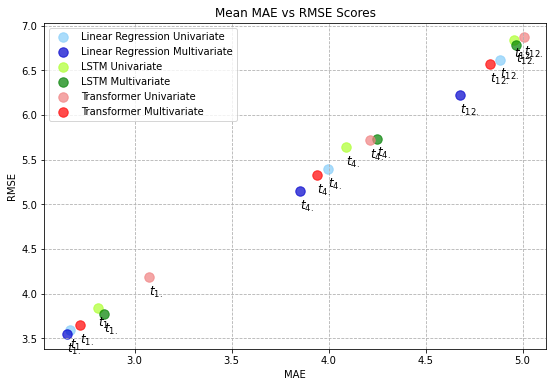

In [136]:
# final summary results: MAE vs RMSE
mae_rmse_results_all(output_lin_all, output_lstm_all, output_trans_all, size=90, lower=0.20, font_size=12)

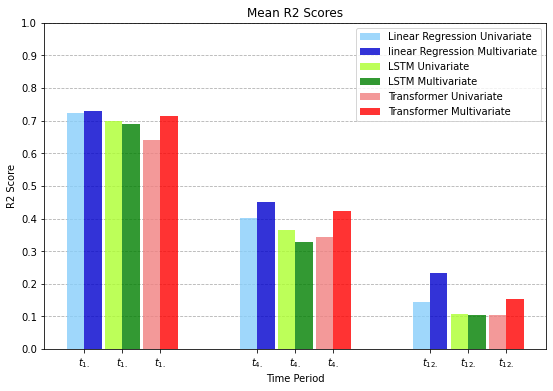

In [137]:
# final summary results: R2-scores
r2_results_all(output_lin_all, output_lstm_all, output_trans_all)

## !END Thesis Notebook: Air Quality Prediction in the Netherlands!